In [68]:
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import multi_dot
from numpy.linalg import inv
from numpy.linalg import det
import pandas as pd
import random
import math

# Auxilary classes and methods

In [69]:
def train_test_split(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_size]
    train_indices = shuffled_indices[test_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [70]:
def feature_normalize(df, mu=None, sigma=None):
    # copy the dataframe
    if df.size == 0:
        return df, None, None
    df_normalized = df.copy()
    if mu is None and sigma is None:
        mu = df_normalized.mean(axis=0)
        sigma = df_normalized.std(axis=0, ddof=1)
    df_normalized = (df_normalized - mu) / sigma
    return df_normalized, mu, sigma

In [71]:
def feature_minmax(df, min_value=None, minmax_gap=None):
    # copy the dataframe
    if df.size == 0:
        return df, None, None
    df_normalized = df.copy()
    if min_value is None and minmax_gap is None:
        min_value = df_normalized.min(axis=0)
        minmax_gap = df_normalized.max(axis=0) - df_normalized.min(axis=0)
    df_normalized = (df_normalized - min_value) / minmax_gap
    return df_normalized, min_value, minmax_gap

In [72]:
# This method transforms a group set vector into a binary group set matrix
def transform_labels(classLabels):
    new_label = np.zeros((len(classLabels), len(np.unique(classLabels))))
    for i in range(len(classLabels)):
        if classLabels[i] == 1:
            new_label[i][0] = 1
        elif classLabels[i] == 2:
            new_label[i][1] = 1
        else:
            new_label[i][2] = 1
    return new_label

In [73]:
def transform_perceptron_sign(array):
    for i in range(len(array)):
        if array[i] == 0:
            array[i] = -1
    return array

def loss(y, y_pred, type_of_loss=None, features_set=None, beta=None):
    y = np.array(y).ravel()
    y_pred = np.array(y_pred).ravel()
    if type_of_loss == 'mse':
        loss = (y - y_pred) ** 2 / len(y)
        return loss
    elif type_of_loss == '0-1':
        # binary classification
        # assume that wine type 1 is for positive, type 2 is for negative
        # however, we have to reassign the group numbers if we classify wine type 3
        if len(np.unique(y_pred)) <= 2:
            loss = np.sum(y != y_pred)
            # false positive: true 2 classified as 1
            type_i_error = np.sum(y_pred < y)
            # false negative: true 1 classified as 2
            type_ii_error = np.sum(y < y_pred)
            return loss, type_i_error, type_ii_error
        else:
            loss = np.sum(y != y_pred)
            return loss
    elif type_of_loss == 'hinge':
        loss = 0
        y = transform_perceptron_sign(y)
        y_pred = transform_perceptron_sign(y_pred)
        for i in range(len(y)):
            if y[i] * y_pred[i] < 1:
                loss += 1 - y[i] * np.dot(features_set[i].T, beta[0])
        return loss
    else: 
        message = 'type of error not specified'
        return message

# Logistic classifier

In [74]:
class LogisticClassifier():
    def __init__(self):
        self.logit_param = None
        self.class_labels = None
        self.mu = None
        self.sigma = None

    def fit(self, features_set, group_set, class_labels, alpha=0.1, num_iter=250, reg_opt = None, lambda_ = 0.01):
        complete_set = pd.concat([group_set, features_set], axis=1)
        sorted_complete_set = pd.merge(class_labels, complete_set, on='Label', sort=False)
        features_set = np.array(sorted_complete_set.iloc[:, 1:])
        features_set, self.mu, self.sigma = feature_normalize(features_set)
        group_set = np.array(sorted_complete_set.iloc[:, 0])
        class_labels = np.array(class_labels).ravel()
        sample_size = features_set.shape[0]
        self.class_labels = class_labels
        
        if len(self.class_labels) == 2:
            weight = np.zeros(features_set.shape[1])
            bias = 0
            class_labels_transform = (group_set==class_labels[0])
            for i in range(num_iter):
                sigma = 1 / (1 + np.exp(-np.dot(features_set, weight) - bias))
                if reg_opt == 'l1': # Lasso regression
                    gradient = np.dot(features_set.T, (sigma * np.ones(sample_size) - class_labels_transform)) / sample_size + lambda_ * np.sign(weight) 
                elif reg_opt == 'l2': # Ridge regression
                    gradient = np.dot(features_set.T, (sigma * np.ones(sample_size) - class_labels_transform)) / sample_size + lambda_ * weight 
                else:
                    gradient = np.dot(features_set.T, (sigma * np.ones(sample_size) - class_labels_transform)) / sample_size
                #db = np.sum(sigma - group_set) / features_set.shape[0]
                db = np.sum(sigma * np.ones(features_set.shape[0]) - (group_set==class_labels[0])) / sample_size
                weight -= alpha * gradient
                bias -= alpha * db
        else:
            weight = np.zeros((features_set.shape[1], len(np.unique(group_set))))
            bias = 0
            class_labels_transform = transform_labels(group_set)
            for i in range(num_iter):
                # sigma = np.exp(np.dot(featuresSet, weight) + bias) / 1 + np.sum(np.exp(np.dot(featuresSet, weight) + bias))
                # sigma = softmax(np.dot(features_set, weight) + bias)
                sigma = np.exp(np.dot(features_set, weight) + bias) / np.sum(np.exp(np.dot(features_set, weight) + bias), axis = 1).reshape(-1, 1)
                if reg_opt == 'l1': # Lasso regression
                    gradient = np.dot(features_set.T, (sigma - class_labels_transform)) / sample_size + lambda_ * np.sign(weight) 
                elif reg_opt == 'l2': # Ridge regression
                    gradient = np.dot(features_set.T, (sigma - class_labels_transform)) / sample_size + lambda_ * weight
                else:
                    gradient = np.dot(features_set.T, (sigma - class_labels_transform)) / sample_size
                db = np.sum(sigma - class_labels_transform) / features_set.shape[0]
                weight -= alpha * gradient
                bias -= alpha * db
        self.logit_param = weight, bias
        return self

    def predict(self, features_set):
        features_set = feature_normalize(features_set, self.mu, self.sigma)[0]
        if len(self.class_labels) == 2:
            result = 1 / (1 + np.exp(-np.dot(features_set, self.logit_param[0]) - self.logit_param[1]))
            # y_pred = np.where(result >= 0.5, 1, 0)
            y_pred = np.zeros(result.shape[0])
            for i in range(len(y_pred)):
                if result[i] >= 0.5:  # threshold = 0.5
                    y_pred[i] = self.class_labels[0]
                else:
                    y_pred[i] = self.class_labels[1]
        else:
            # result = np.exp(np.dot(featuresSet, logit_param[0]) + logit_param[1]) / 1 + np.sum(np.exp(np.dot(featuresSet, logit_param[0]) + logit_param[1]))
            # result = softmax(np.dot(features_set, self.logit_param[0]) + self.logit_param[1])
            result = np.exp(np.dot(features_set, self.logit_param[0]) + self.logit_param[1]) / np.sum(np.exp(np.dot(features_set, self.logit_param[0]) + self.logit_param[1]), axis = 1).reshape(-1, 1)
            y_pred = self.class_labels[np.argmax(result, axis=1)]
        return y_pred

# Perceptron

In [75]:
def step(features_set, weight, bias):
        z = np.dot(weight, features_set) + bias
        if z >= 0:
            return 1
        else:
            return 0
        
class Perceptron():

    def __init__(self):
        self.class_labels = None
        self.beta = None
        self.min_value = None
        self.minmax_gap = None

    def fit(self, features_set, group_set, class_labels, alpha=0.1, num_iter=250):
        complete_set = pd.concat([group_set, features_set], axis=1)
        sorted_complete_set = pd.merge(class_labels, complete_set, on='Label', sort=False)
        features_set = np.array(sorted_complete_set.iloc[:, 1:])
        features_set, self.min_value, self.minmax_gap = feature_minmax(features_set)
        group_set = np.array(sorted_complete_set.iloc[:, 0])
        class_labels = np.array(class_labels).ravel()
        self.class_labels = class_labels
        class_labels_transform = (group_set==class_labels[0])
        weight = np.zeros(features_set.shape[1])
        bias = 0
        for i in range(num_iter):
            for m in range(len(features_set)):
                y_ = step(features_set[m], weight, bias)
                for n in range(len(weight)):
                    weight[n] += alpha * (class_labels_transform[m] - y_) * features_set[m][n]
                    bias += alpha * (class_labels_transform[m] - y_)
        self.beta = weight, bias
        return self

    def predict(self, features_set):
        features_set = feature_normalize(features_set, self.min_value, self.minmax_gap)[0]
        result = np.dot(features_set, self.beta[0]) + self.beta[1]
        y_pred = np.zeros(result.shape[0])
        for i in range(len(y_pred)):
            if result[i] >= 0:
                y_pred[i] = self.class_labels[0]
            else:
                y_pred[i] = self.class_labels[1]
        return y_pred

# K nearest neighbours

In [76]:
def KNN_fit(train_sample, train_class, test, k):
    train_sample, mu, sigma = feature_normalize(train_sample)
    train_sample = np.array(train_sample)
    train_class = np.array(train_class).ravel().astype(np.int)
    test = feature_normalize(test, mu, sigma)[0]
    test = np.array(test)
    sample_size = train_sample.shape[0]
    test_size = test.shape[0]
    result = []
    for i in range(test_size):
        distance_all = []
        for j in range(sample_size):
            distance = np.sum((test[i] - train_sample[j])**2)
            distance_all.append(distance)
        neighbours_index = np.argsort(distance_all)[0 : k]
        class_counts = np.bincount(train_class[neighbours_index])
        most_frequent_class = np.argmax(class_counts)
        result.append(most_frequent_class)
    return result

# Binary classification

In [77]:
# import data
data = pd.read_csv('wine.csv', header = None)
column_names = ['Label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash',
                'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
                'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                'Proline']
wine = pd.DataFrame(data)
wine.columns = column_names

In [78]:
train_sample, test_sample = train_test_split(wine, 0.2)

In [79]:
# Choose predictors
train_features_set = train_sample[train_sample['Label'].isin([1, 3])][['Alcalinity of ash','Proanthocyanins']]
train_group_set = train_sample[train_sample['Label'].isin([1, 3])][['Label']]
class_labels = pd.DataFrame([1, 3], columns=['Label'])
test_features_set = test_sample[test_sample['Label'].isin([1, 3])][['Alcalinity of ash','Proanthocyanins']]
test_group_set = test_sample[test_sample['Label'].isin([1, 3])].iloc[:, 0]

## Logistic classifier

### Choosing regularization parameter using cross validation

#### For Lasso

In [80]:
n_train = train_features_set.shape[0]
num_fold = 5
n_fold = math.floor(n_train / num_fold)

total_error_all = []
type_i_error_all = []
type_ii_error_all = []
meshgrid = np.arange(0, 0.1, 0.01)

features_set = train_features_set
group_set = train_group_set

for lambda_ in meshgrid:
    total_error = 0
    type_i_error = 0
    type_ii_error = 0
    for cur_fold in range(num_fold):
        features_set_fold = features_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
        group_set_fold = group_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
        features_set_train_fold = features_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
        group_set_train_fold = group_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]

        pr = LogisticClassifier().fit(features_set_train_fold, group_set_train_fold, class_labels, reg_opt='l1', lambda_ = lambda_)
        group_set_pred = pr.predict(features_set_fold)
        total_error += loss(group_set_fold, group_set_pred, '0-1')[0]
        type_i_error += loss(group_set_fold, group_set_pred, '0-1')[1]
        type_ii_error += loss(group_set_fold, group_set_pred, '0-1')[2]
    total_error_all.append(total_error)
    type_i_error_all.append(type_i_error)
    type_ii_error_all.append(type_ii_error)
    
best_lambda = meshgrid[np.argsort(total_error_all)[0]]
print(best_lambda)

0.02


#### For Ridge

In [81]:
n_train = train_features_set.shape[0]
num_fold = 5
n_fold = math.floor(n_train / num_fold)

total_error_all = []
type_i_error_all = []
type_ii_error_all = []
meshgrid = np.arange(0, 0.1, 0.01)

features_set = train_features_set
group_set = train_group_set

for lambda_ in meshgrid:
    total_error = 0
    type_i_error = 0
    type_ii_error = 0
    for cur_fold in range(num_fold):
        features_set_fold = features_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
        group_set_fold = group_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
        features_set_train_fold = features_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
        group_set_train_fold = group_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]

        pr = LogisticClassifier().fit(features_set_train_fold, group_set_train_fold, class_labels, reg_opt='l2', lambda_ = lambda_)
        group_set_pred = pr.predict(features_set_fold)
        total_error += loss(group_set_fold, group_set_pred, '0-1')[0]
        type_i_error += loss(group_set_fold, group_set_pred, '0-1')[1]
        type_ii_error += loss(group_set_fold, group_set_pred, '0-1')[2]
    total_error_all.append(total_error)
    type_i_error_all.append(type_i_error)
    type_ii_error_all.append(type_ii_error)
    
best_lambda = meshgrid[np.argsort(total_error_all)[0]]
print(best_lambda)

0.02


### Training and testing error without the regularization parameter

In [82]:
lr = LogisticClassifier().fit(train_features_set, train_group_set, class_labels)
train_group_set_pred = lr.predict(train_features_set)
test_group_set_pred = lr.predict(test_features_set)

In [83]:
result = pd.Series(loss(train_group_set, train_group_set_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      7
type_i_error     4
type_ii_error    3
dtype: int64


In [84]:
result = pd.Series(loss(test_group_set, test_group_set_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      2
type_i_error     1
type_ii_error    1
dtype: int64


### Training and testing error for Lasso regression

In [85]:
lr = LogisticClassifier().fit(train_features_set, train_group_set, class_labels, reg_opt = 'l1', lambda_ = 0.02)
train_group_set_pred = lr.predict(train_features_set)
test_group_set_pred = lr.predict(test_features_set)

In [86]:
result = pd.Series(loss(train_group_set, train_group_set_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      7
type_i_error     4
type_ii_error    3
dtype: int64


In [87]:
result = pd.Series(loss(test_group_set, test_group_set_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      2
type_i_error     1
type_ii_error    1
dtype: int64


### Training and testing error for Ridge regression

In [88]:
lr = LogisticClassifier().fit(train_features_set, train_group_set, class_labels, reg_opt = 'l2', lambda_ = 0.02)
train_group_set_pred = lr.predict(train_features_set)
test_group_set_pred = lr.predict(test_features_set)

In [89]:
result = pd.Series(loss(train_group_set, train_group_set_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      7
type_i_error     4
type_ii_error    3
dtype: int64


In [90]:
result = pd.Series(loss(test_group_set, test_group_set_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      2
type_i_error     1
type_ii_error    1
dtype: int64


### Classification result plot

<function matplotlib.pyplot.show(close=None, block=None)>

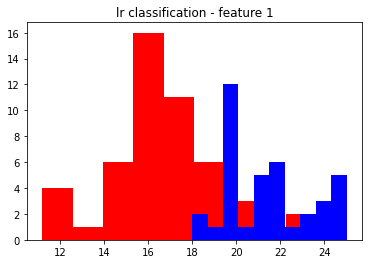

In [91]:
fig = plt.figure()

lr_plot_1 = train_features_set.iloc[:, 0]
lr_plot_2 = train_group_set_pred
lr_plot = np.column_stack((lr_plot_1, lr_plot_2))
lr_plot_x1 = lr_plot[lr_plot[:, 1] == 1]
lr_plot_x2 = lr_plot[lr_plot[:, 1] == 3]

zeros1 = np.zeros((len(lr_plot_x1[:, 0]), 1))
zeros2 = np.zeros((len(lr_plot_x2[:, 0]), 1))
plt.hist(lr_plot_x1[:, 0], color='red')
plt.hist(lr_plot_x2[:, 0], color='blue')

plt.title('lr classification - feature 1')
plt.show

## Perceptron

### Training and testing error

In [92]:
p = Perceptron().fit(train_features_set, train_group_set, class_labels)
train_group_set_pred = p.predict(train_features_set)
test_group_set_pred = p.predict(test_features_set)

In [93]:
result = pd.Series(loss(train_group_set, train_group_set_pred, 'hinge', train_features_set, p.beta), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      0
type_i_error     0
type_ii_error    0
dtype: int64


In [94]:
result = pd.Series(loss(test_group_set, test_group_set_pred, 'hinge', test_features_set, p.beta), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      0
type_i_error     0
type_ii_error    0
dtype: int64


## KNN

### Choosing the number of neighbours using cross validation

In [95]:
n_train = train_features_set.shape[0]
num_fold = 10
n_fold = math.floor(n_train / num_fold)

total_error_all = []
type_i_error_all = []
type_ii_error_all = []
meshgrid = np.arange(1, 30, 1)

features_set = train_features_set
group_set = train_group_set

for k in meshgrid:
    total_error = 0
    type_i_error = 0
    type_ii_error = 0
    for cur_fold in range(num_fold):
        features_set_fold = features_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
        group_set_fold = group_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
        features_set_train_fold = features_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
        group_set_train_fold = group_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]

        group_set_pred = KNN_fit(features_set_train_fold, group_set_train_fold, features_set_fold, k)
        total_error += loss(group_set_fold, group_set_pred, '0-1')[0]
        type_i_error += loss(group_set_fold, group_set_pred, '0-1')[1]
        type_ii_error += loss(group_set_fold, group_set_pred, '0-1')[2]
    total_error_all.append(total_error)
    type_i_error_all.append(type_i_error)
    type_ii_error_all.append(type_ii_error)
    
best_k = meshgrid[np.argsort(total_error_all)[0]]
print(best_k)

29


### Training and testing error

In [97]:
train_group_pred = KNN_fit(train_features_set, train_group_set, train_features_set, 29)
test_group_pred = KNN_fit(train_features_set, train_group_set, test_features_set, 29)

In [98]:
result = pd.Series(loss(train_group_set, train_group_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      6
type_i_error     4
type_ii_error    2
dtype: int64


In [99]:
result = pd.Series(loss(test_group_set, test_group_pred, '0-1'), index = ['total_error', 'type_i_error', 'type_ii_error'])
print(result)

total_error      2
type_i_error     1
type_ii_error    1
dtype: int64


# 3-Classes classification

In [100]:
# Choose predictors
train_features_set = train_sample[['Alcohol', 'Flavanoids', 'Proanthocyanins', 'Color intensity']]
train_group_set = train_sample[['Label']]
class_labels = pd.DataFrame([1, 2, 3], columns=['Label'])
test_features_set = test_sample[['Alcohol', 'Flavanoids', 'Proanthocyanins', 'Color intensity']]
test_group_set = test_sample[['Label']]

## Logistic classifier

### Choosing regularization parameter using cross validation

#### For Lasso

In [106]:
n_train = train_features_set.shape[0]
num_fold = 5
n_fold = math.floor(n_train / num_fold)

total_error_all = []
type_i_error_all = []
type_ii_error_all = []
meshgrid = np.arange(0, 0.1, 0.01)

features_set = train_features_set
group_set = train_group_set

for lambda_ in meshgrid:
    total_error = 0
    for cur_fold in range(num_fold):
        features_set_fold = features_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
        group_set_fold = group_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
        features_set_train_fold = features_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
        group_set_train_fold = group_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]

        pr = LogisticClassifier().fit(features_set_train_fold, group_set_train_fold, class_labels, reg_opt='l1', lambda_ = lambda_)
        group_set_pred = pr.predict(features_set_fold)
        total_error += loss(group_set_fold, group_set_pred, '0-1')
    total_error_all.append(total_error)
    
best_lambda = meshgrid[np.argsort(total_error_all)[0]]
print(best_lambda)

0.0


In [107]:
n_train = train_features_set.shape[0]
num_fold = 5
n_fold = math.floor(n_train / num_fold)

total_error_all = []
type_i_error_all = []
type_ii_error_all = []
meshgrid = np.arange(0, 0.1, 0.01)

features_set = train_features_set
group_set = train_group_set

for lambda_ in meshgrid:
    total_error = 0
    for cur_fold in range(num_fold):
        features_set_fold = features_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
        group_set_fold = group_set.iloc[cur_fold * n_fold : (cur_fold + 1) * n_fold]
        features_set_train_fold = features_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]
        group_set_train_fold = group_set.iloc[np.r_[0 : cur_fold * n_fold, (cur_fold + 1) * n_fold : n_train]]

        pr = LogisticClassifier().fit(features_set_train_fold, group_set_train_fold, class_labels, reg_opt='l2', lambda_ = lambda_)
        group_set_pred = pr.predict(features_set_fold)
        total_error += loss(group_set_fold, group_set_pred, '0-1')
    total_error_all.append(total_error)
    
best_lambda = meshgrid[np.argsort(total_error_all)[0]]
print(best_lambda)

0.0


## Training and testing error without regularization parameter

In [101]:
lr = LogisticClassifier().fit(train_features_set, train_group_set, class_labels)
train_group_set_pred = lr.predict(train_features_set)
test_group_set_pred = lr.predict(test_features_set)

In [102]:
result = pd.Series(loss(train_group_set, train_group_set_pred, '0-1'), index = ['total_error'])
print(result)

total_error    10
dtype: int32


In [103]:
result = pd.Series(loss(test_group_set, test_group_set_pred, '0-1'), index = ['total_error'])
print(result)

total_error    2
dtype: int32
